<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

tic = time.time()  # Start the timer
initial_run = 0


### Set Random Seeds

In [3]:
##  Random Seed
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
## ------------------

Set Logic-Values


In [4]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

In [5]:
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


# believe I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)


dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteHBRPOI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
There are ways to count and verify the number per training set which i have hidden because they are costly
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


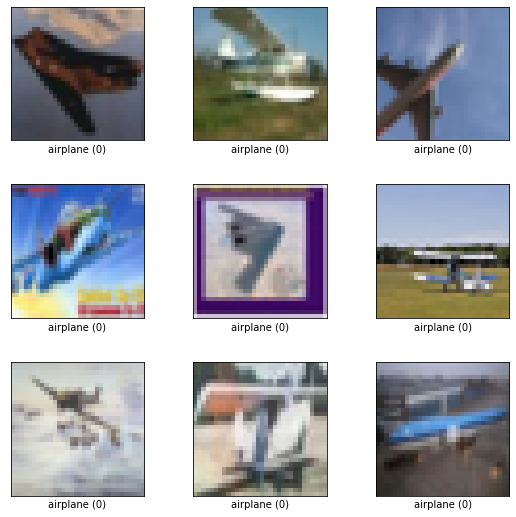

In [6]:
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

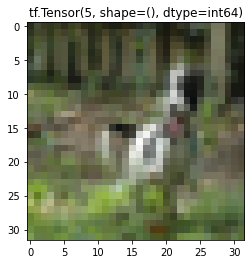

In [7]:
img, label = next(iter(dataset_dogs))

#print(img)
plt.title(str(label))
plt.imshow(img)

# Create validation set of 10,000 images

In [8]:
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Create 9 small groups of training_sets

 I "shard" the remaining training set into 16 groups and save 9 of them.

#### Airplanes (airplanes_A, ... airplanes_P)

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=16, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=16, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=16, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=16, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=16, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=16, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=16, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=16, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=16, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=16, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=16, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=16, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=16, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=16, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=16, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Automobiles

In [10]:
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=16, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=16, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=16, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=16, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=16, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=16, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=16, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=16, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=16, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=16, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=16, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=16, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=16, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=16, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=16, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Birds

In [11]:
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=16, index = 0)
birds_B = dataset_birds.shard(num_shards=16, index = 1)
birds_C = dataset_birds.shard(num_shards=16, index = 2)
birds_D = dataset_birds.shard(num_shards=16, index = 3)
birds_E = dataset_birds.shard(num_shards=16, index = 4)
birds_F = dataset_birds.shard(num_shards=16, index = 5)
birds_G = dataset_birds.shard(num_shards=16, index = 6)
birds_H = dataset_birds.shard(num_shards=16, index = 7)
birds_I = dataset_birds.shard(num_shards=16, index = 8)
birds_J = dataset_birds.shard(num_shards=16, index = 9)
birds_K = dataset_birds.shard(num_shards=16, index = 10)
birds_L = dataset_birds.shard(num_shards=16, index = 11)
birds_M = dataset_birds.shard(num_shards=16, index = 12)
birds_N = dataset_birds.shard(num_shards=16, index = 13)
birds_O = dataset_birds.shard(num_shards=16, index = 14)
birds_P = dataset_birds.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Cats

In [12]:
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=16, index = 0)
cats_B = dataset_cats.shard(num_shards=16, index = 1)
cats_C = dataset_cats.shard(num_shards=16, index = 2)
cats_D = dataset_cats.shard(num_shards=16, index = 3)
cats_E = dataset_cats.shard(num_shards=16, index = 4)
cats_F = dataset_cats.shard(num_shards=16, index = 5)
cats_G = dataset_cats.shard(num_shards=16, index = 6)
cats_H = dataset_cats.shard(num_shards=16, index = 7)
cats_I = dataset_cats.shard(num_shards=16, index = 8)
cats_J = dataset_cats.shard(num_shards=16, index = 9)
cats_K = dataset_cats.shard(num_shards=16, index = 10)
cats_L = dataset_cats.shard(num_shards=16, index = 11)
cats_M = dataset_cats.shard(num_shards=16, index = 12)
cats_N = dataset_cats.shard(num_shards=16, index = 13)
cats_O = dataset_cats.shard(num_shards=16, index = 14)
cats_P = dataset_cats.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Deer(s)

In [13]:
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=16, index = 0)
deers_B = dataset_deers.shard(num_shards=16, index = 1)
deers_C = dataset_deers.shard(num_shards=16, index = 2)
deers_D = dataset_deers.shard(num_shards=16, index = 3)
deers_E = dataset_deers.shard(num_shards=16, index = 4)
deers_F = dataset_deers.shard(num_shards=16, index = 5)
deers_G = dataset_deers.shard(num_shards=16, index = 6)
deers_H = dataset_deers.shard(num_shards=16, index = 7)
deers_I = dataset_deers.shard(num_shards=16, index = 8)
deers_J = dataset_deers.shard(num_shards=16, index = 9)
deers_K = dataset_deers.shard(num_shards=16, index = 10)
deers_L = dataset_deers.shard(num_shards=16, index = 11)
deers_M = dataset_deers.shard(num_shards=16, index = 12)
deers_N = dataset_deers.shard(num_shards=16, index = 13)
deers_O = dataset_deers.shard(num_shards=16, index = 14)
deers_P = dataset_deers.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Dogs

In [14]:
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=16, index = 0)
dogs_B = dataset_dogs.shard(num_shards=16, index = 1)
dogs_C = dataset_dogs.shard(num_shards=16, index = 2)
dogs_D = dataset_dogs.shard(num_shards=16, index = 3)
dogs_E = dataset_dogs.shard(num_shards=16, index = 4)
dogs_F = dataset_dogs.shard(num_shards=16, index = 5)
dogs_G = dataset_dogs.shard(num_shards=16, index = 6)
dogs_H = dataset_dogs.shard(num_shards=16, index = 7)
dogs_I = dataset_dogs.shard(num_shards=16, index = 8)
dogs_J = dataset_dogs.shard(num_shards=16, index = 9)
dogs_K = dataset_dogs.shard(num_shards=16, index = 10)
dogs_L = dataset_dogs.shard(num_shards=16, index = 11)
dogs_M = dataset_dogs.shard(num_shards=16, index = 12)
dogs_N = dataset_dogs.shard(num_shards=16, index = 13)
dogs_O = dataset_dogs.shard(num_shards=16, index = 14)
dogs_P = dataset_dogs.shard(num_shards=16, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [15]:
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=16, index = 0)
frogs_B = dataset_frogs.shard(num_shards=16, index = 1)
frogs_C = dataset_frogs.shard(num_shards=16, index = 2)
frogs_D = dataset_frogs.shard(num_shards=16, index = 3)
frogs_E = dataset_frogs.shard(num_shards=16, index = 4)
frogs_F = dataset_frogs.shard(num_shards=16, index = 5)
frogs_G = dataset_frogs.shard(num_shards=16, index = 6)
frogs_H = dataset_frogs.shard(num_shards=16, index = 7)
frogs_I = dataset_frogs.shard(num_shards=16, index = 8)
frogs_J = dataset_frogs.shard(num_shards=16, index = 9)
frogs_K = dataset_frogs.shard(num_shards=16, index = 10)
frogs_L = dataset_frogs.shard(num_shards=16, index = 11)
frogs_M = dataset_frogs.shard(num_shards=16, index = 12)
frogs_N = dataset_frogs.shard(num_shards=16, index = 13)
frogs_O = dataset_frogs.shard(num_shards=16, index = 14)
frogs_P = dataset_frogs.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Horses

In [16]:
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=16, index = 0)
horses_B = dataset_horses.shard(num_shards=16, index = 1)
horses_C = dataset_horses.shard(num_shards=16, index = 2)
horses_D = dataset_horses.shard(num_shards=16, index = 3)
horses_E = dataset_horses.shard(num_shards=16, index = 4)
horses_F = dataset_horses.shard(num_shards=16, index = 5)
horses_G = dataset_horses.shard(num_shards=16, index = 6)
horses_H = dataset_horses.shard(num_shards=16, index = 7)
horses_I = dataset_horses.shard(num_shards=16, index = 8)
horses_J = dataset_horses.shard(num_shards=16, index = 9)
horses_K = dataset_horses.shard(num_shards=16, index = 10)
horses_L = dataset_horses.shard(num_shards=16, index = 11)
horses_M = dataset_horses.shard(num_shards=16, index = 12)
horses_N = dataset_horses.shard(num_shards=16, index = 13)
horses_O = dataset_horses.shard(num_shards=16, index = 14)
horses_P = dataset_horses.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Ships

In [17]:
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=16, index = 0)
ships_B = dataset_ships.shard(num_shards=16, index = 1)
ships_C = dataset_ships.shard(num_shards=16, index = 2)
ships_D = dataset_ships.shard(num_shards=16, index = 3)
ships_E = dataset_ships.shard(num_shards=16, index = 4)
ships_F = dataset_ships.shard(num_shards=16, index = 5)
ships_G = dataset_ships.shard(num_shards=16, index = 6)
ships_H = dataset_ships.shard(num_shards=16, index = 7)
ships_I = dataset_ships.shard(num_shards=16, index = 8)
ships_J = dataset_ships.shard(num_shards=16, index = 9)
ships_K = dataset_ships.shard(num_shards=16, index = 10)
ships_L = dataset_ships.shard(num_shards=16, index = 11)
ships_M = dataset_ships.shard(num_shards=16, index = 12)
ships_N = dataset_ships.shard(num_shards=16, index = 13)
ships_O = dataset_ships.shard(num_shards=16, index = 14)
ships_P = dataset_ships.shard(num_shards=16, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Trucks


In [18]:
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=16, index = 0)
trucks_B = dataset_trucks.shard(num_shards=16, index = 1)
trucks_C = dataset_trucks.shard(num_shards=16, index = 2)
trucks_D = dataset_trucks.shard(num_shards=16, index = 3)
trucks_E = dataset_trucks.shard(num_shards=16, index = 4)
trucks_F = dataset_trucks.shard(num_shards=16, index = 5)
trucks_G = dataset_trucks.shard(num_shards=16, index = 6)
trucks_H = dataset_trucks.shard(num_shards=16, index = 7)
trucks_I = dataset_trucks.shard(num_shards=16, index = 8)
trucks_J = dataset_trucks.shard(num_shards=16, index = 9)
trucks_K = dataset_trucks.shard(num_shards=16, index = 10)
trucks_L = dataset_trucks.shard(num_shards=16, index = 11)
trucks_M = dataset_trucks.shard(num_shards=16, index = 12)
trucks_N = dataset_trucks.shard(num_shards=16, index = 13)
trucks_O = dataset_trucks.shard(num_shards=16, index = 14)
trucks_P = dataset_trucks.shard(num_shards=16, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Merge 1/16th of each CIFAR Training Datasets into 16 Small training Groups {A}, {B}, {C} , ... {P}

#### Group A  (train_A)

In [19]:
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i)
# print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group B

In [20]:
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [21]:
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [22]:
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [23]:
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [24]:
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [25]:
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [26]:
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [27]:
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [28]:
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

### Adding Batches, Buffers, Shuffles and Caches

The following is necessary to run the datasets through the models.  Do not run the following more than once because it'll try to make an additional dimension in your datasets

In [29]:
if initial_run == 0: 
    
  AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(2500, reshuffle_each_iteration=True, seed=seed)
  train_A = train_A.batch(100)  # I believe its good to not have a remainder to cut ds evenly but I'm not sure

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  x_test = x_test.cache().prefetch(tf.data.AUTOTUNE)
  x_test = x_test.batch(10000)

else:
  pass

initial_run = initial_run+1

#### Time required to create datasets: 108 seconds

In [30]:
toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 74.3616 seconds


# Train CNN on Training_Group_A

Train a vanilla CNN using small group A train set, the val set, and test

## Train the model :


In [31]:
# Make a Vanilla CNN
num_classes = 10
input_shape = (32, 32, 3)

# For Reference these are the defaults
# kernel_initializer="glorot_uniform",
# bias_initializer="zeros",
# padding="valid",  #valid = no padding
# kernel_regularizer=None,
# bias_regularizer=None,
# activity_regularizer=None,

initializer = tf.keras.initializers.HeUniform(seed)

model = tf.keras.Sequential(
[
    #keras.Input(),
    tf.keras.Input(shape=input_shape),

    layers.experimental.preprocessing.Rescaling(1./255),
    #data_augmentation,   
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
    layers.BatchNormalization(name="BN1"),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
    layers.BatchNormalization(name="BN2"),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
    layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
    layers.BatchNormalization(name="BN3"),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu", kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")

])


model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])  #changed, added to val_accuracy

model.save_weights('saved_model/blank_model')
model.load_weights('saved_model/blank_model')


if run_model == True:

  history = model.fit(
    train_A,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=10, restore_best_weights=True), 
    verbose=0
  )

  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  model.save('saved_model/my_model')

#### Time Required to Train and Validate (Baseline) 64 seconds

In [32]:
tock = time.time()  
# print(tock - toc, " seconds")
print(f"Trained model in {tock - toc:0.4f} seconds")

Trained model in 0.3609 seconds


# Evaluate Model on Test Set

In [33]:

if run_model == True:
  model.evaluate(x_test, verbose=2) 

When the training dataset has a shuffle-per-iteration with a pseudo-random seed the following test accuracies resulst: 0.5346999, 0.5309, 0.5479, 0.5479 again, 0.5429


### Confusion Matrix on Test-Set Data 

In [34]:

if run_model == True:

  y_pred = model.predict(x_test)
  # I need to convert this large y_pred of continuous probabilities into a 1-coded label vectors
  y_pred_1hot = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
  # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
  print(cm)

## Confusion Matrix of Training-Cats Dataset (for sanity check)

I wanted to verify the confusion matrix was working, so I sent just `cats_A`, through the predictive model.  I figured out that scikits `confusion_matrix` only saw and used the numerical values from the prediction and that's why it looked like it was skipping an index.  Thanks [SO](https://stackoverflow.com/questions/35162652/construct-confusion-matrix-with-missing-data)  

In [35]:

if run_model == True:
  if initial_run == 1:
   cats_A = cats_A.batch(250)

In [36]:

if run_model == True:
  preds_cats = model.predict(cats_A)
  preds_cats = np.argmax(preds_cats, axis=1)
  y_cats = get_labels_from_tfdataset(cats_A)
  cm2 = confusion_matrix(y_true = y_cats, y_pred = preds_cats , labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Adding these labels is super important on this function
  # disp2 = ConfusionMatrixDisplay(cm2, display_labels= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']).plot()

In [37]:

if run_model == True:

  CLASSES = info.features['label'].names

  def show_confusion_matrix(test_labels, predictions, CLASSES):
    """Compute confusion matrix and normalize."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    confusing_part_matrix= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)
    # print(confusing_part_matrix)
    # print(confusion)
    # print(confusion.astype("float"))
    # print(confusion.sum(axis=1))
    # # confusion_normalized = np.divide(confusion.astype("float"), confusion.sum(axis=1))
    # confusion_normalized = np.where(confusing_part_matrix> 0, np.divide(confusing_part_matrix.astype("float"), confusing_part_matrix.sum(axis=1)), 0)
    axis_labels = CLASSES
    # ax = sns.heatmap(
    #     confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
    #     cmap='Blues', annot=True, fmt='.2f', square=True)
    ax = sns.heatmap(
        confusing_part_matrix, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, square=True, fmt='.0f')

    plt.title("Confusion matrix without Diagonal")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

  
  # show_confusion_matrix(y_cats, preds_cats, CLASSES = CLASSES)  # this is the training set, so a lot less will show up on the confusion matrix, I got four on this run

  # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
  show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

### I Attempted to get misclassified images to show but have been failing

In [38]:

if run_model == True:
  # fig = tfds.show_examples(tf.data.Dataset.unbatch(cats_A), info)

  # I want to identify images that wer not predicted as cats
  errors = ( preds_cats - 3 !=0 )  # IF predicted class is 3, then a correct prediction yields 3-3 = 0.  

  #print(errors) # this prints the answer to 250 questions, I just want the index of the wrong ones with respect to the 250

  index, = np.where(errors == True)
  print(index)

  

# Transition to Augmentations


In [39]:
import time
start_augmentations = time.time()

## Prepare the Google Colab environment

#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [40]:
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations
# necessary imports
from functools import partial
import albumentations as A

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-asve0jq0
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-asve0jq0
     |████████████████████████████████| 47.6 MB 66 kB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=103057 sha256=807cc09fb3a41f548118642c4b1f0f0c3c060742899473e3ad464a3d53b1bc93
  Stored in directory: /tmp/pip-ephem-wheel-cache-x6jgms2v/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Augmentation Factors and Levels

The following are the 19 chosen data-augmentation techniques and the one regularization factor "*Dropout*" Percent Level, to compare with.  

|Order | Factors | Low | High | Center  |
| -: | :- | :-: | :-: | :-: | 
|1 | *DropoutPercent* | 0 | 50 | 25| 
|2 | FlipHorizontal | No | Yes | NA| 
|3 | FlipVertical | No | Yes | NA| 
|4 | ShiftHorizontal | 0 | 10 | 5| 
|5 | ShiftVertical | 0 | 10 | 5| 
|6 | ZoomOut | 0 | 0.2 | 0.1| 
|7 | Gamma | 0 | 1 | 0.5| 
|8 | Noise | 0 | 8 | 4| 
|9 | Blur | 0 | 8 | 4| 
|10 | FancyPCA | No | Yes | NA| 
|11 | ChannelShuffle | No | Yes | NA| 
|12 | HistogramEqualizer | No | Yes | NA| 
|13 | Rotate | 0 | 30 | 15| 
|14 | Brighten | 0 | 10 | 5| 
|15 | Contrast | 0 | 1 | 0.5| 
|16 | ElasticTransform | 0 | 1 | 0.5| 
|17 | Darken | 0 | 10 | 5| 
|18 | RandomCrop | 32 | 16 | 24| 
|19 | ZoomIn | 0 | 0.2 | 0.1| 
|20 | ToGray | No | Yes | NA| 


A 42-run definitive screening design with no blocks is used to see which main effects are most important.

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


## Standard-Order Definitive Screening Design 
### Experimental Runs with Low, High, Center Levels (Not Randomized for Visual) 

  There are 42 runs, for assessing 19 factors.  The Factor Levels are shown as "0" for low, "1" for high, and "0.5" for center points to assess for curvature in the model.

Run | DropoutPercent | FlipHorizontal | FlipVertical | ShiftHorizontal | ShiftVertical | ZoomOut | Gamma | Noise | Blur | FancyPCA | ChannelShuffle | Histogram Equalizer | Rotate | Contrast | Brighten | Darken | ElasticTransform | RandomCrop | ZoomIn | ToGray | 
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
1 | 0.5 | Yes | Yes | 1 | 1 | 1 | 1 | 1 | 1 | Yes | Yes | Yes | 1 | 1 | 1 | 1 | 1 | 1 | 1 | Yes
2 | 0.5 | No | No | 0 | 0 | 0 | 0 | 0 | 0 | No | No | No | 0 | 0 | 0 | 0 | 0 | 0 | 0 | No
3 | 1 | No | No | 0.5 | 1 | 0 | 0 | 1 | 1 | No | Yes | Yes | 1 | 1 | 0 | 1 | 0 | 1 | 0 | No
4 | 0 | Yes | Yes | 0.5 | 0 | 1 | 1 | 0 | 0 | Yes | No | No | 0 | 0 | 1 | 0 | 1 | 0 | 1 | Yes
5 | 1 | No | No | 0 | 0.5 | 1 | 0 | 0 | 1 | No | No | Yes | 1 | 1 | 1 | 0 | 1 | 0 | 1 | Yes
6 | 0 | Yes | Yes | 1 | 0.5 | 0 | 1 | 1 | 0 | Yes | Yes | No | 0 | 0 | 0 | 1 | 0 | 1 | 0 | No
7 | 1 | Yes | No | 1 | 0 | 0.5 | 1 | 0 | 0 | No | No | No | 1 | 1 | 1 | 1 | 0 | 1 | 0 | Yes
8 | 0 | No | Yes | 0 | 1 | 0.5 | 0 | 1 | 1 | Yes | Yes | Yes | 0 | 0 | 0 | 0 | 1 | 0 | 1 | No
9 | 1 | No | Yes | 1 | 1 | 0 | 0.5 | 1 | 0 | No | No | No | 0 | 1 | 1 | 1 | 1 | 0 | 1 | No
10 | 0 | Yes | No | 0 | 0 | 1 | 0.5 | 0 | 1 | Yes | Yes | Yes | 1 | 0 | 0 | 0 | 0 | 1 | 0 | Yes
11 | 1 | Yes | No | 0 | 1 | 1 | 0 | 0.5 | 1 | Yes | No | No | 0 | 0 | 1 | 1 | 1 | 1 | 0 | No
12 | 0 | No | Yes | 1 | 0 | 0 | 1 | 0.5 | 0 | No | Yes | Yes | 1 | 1 | 0 | 0 | 0 | 0 | 1 | Yes
13 | 1 | No | Yes | 0 | 0 | 1 | 1 | 0 | 0.5 | No | Yes | No | 1 | 0 | 0 | 1 | 1 | 1 | 1 | No
14 | 0 | Yes | No | 1 | 1 | 0 | 0 | 1 | 0.5 | Yes | No | Yes | 0 | 1 | 1 | 0 | 0 | 0 | 0 | Yes
15 | 1 | Yes | No | 0 | 0 | 0 | 1 | 1 | 0 | Yes | No | Yes | 0.5 | 1 | 0 | 0 | 1 | 1 | 1 | No
16 | 0 | No | Yes | 1 | 1 | 1 | 0 | 0 | 1 | No | Yes | No | 0.5 | 0 | 1 | 1 | 0 | 0 | 0 | Yes
17 | 1 | Yes | Yes | 0 | 0 | 0 | 0 | 1 | 1 | No | Yes | No | 0 | 0.5 | 1 | 0 | 0 | 1 | 1 | Yes
18 | 0 | No | No | 1 | 1 | 1 | 1 | 0 | 0 | Yes | No | Yes | 1 | 0.5 | 0 | 1 | 1 | 0 | 0 | No
19 | 1 | Yes | Yes | 1 | 0 | 0 | 0 | 0 | 1 | Yes | No | Yes | 1 | 0 | 0.5 | 1 | 0 | 0 | 1 | No
20 | 0 | No | No | 0 | 1 | 1 | 1 | 1 | 0 | No | Yes | No | 0 | 1 | 0.5 | 0 | 1 | 1 | 0 | Yes
21 | 1 | Yes | Yes | 0 | 1 | 0 | 0 | 0 | 0 | Yes | Yes | No | 1 | 1 | 0 | 0.5 | 1 | 0 | 0 | Yes
22 | 0 | No | No | 1 | 0 | 1 | 1 | 1 | 1 | No | No | Yes | 0 | 0 | 1 | 0.5 | 0 | 1 | 1 | No
23 | 1 | No | Yes | 1 | 0 | 1 | 0 | 0 | 0 | Yes | Yes | Yes | 0 | 1 | 1 | 0 | 0.5 | 1 | 0 | No
24 | 0 | Yes | No | 0 | 1 | 0 | 1 | 1 | 1 | No | No | No | 1 | 0 | 0 | 1 | 0.5 | 0 | 1 | Yes
25 | 1 | No | No | 0 | 1 | 0 | 1 | 0 | 0 | Yes | Yes | Yes | 0 | 0 | 1 | 1 | 0 | 0.5 | 1 | Yes
26 | 0 | Yes | Yes | 1 | 0 | 1 | 0 | 1 | 1 | No | No | No | 1 | 1 | 0 | 0 | 1 | 0.5 | 0 | No
27 | 1 | Yes | No | 1 | 0 | 1 | 0 | 1 | 0 | No | Yes | Yes | 0 | 0 | 0 | 1 | 1 | 0 | 0.5 | Yes
28 | 0 | No | Yes | 0 | 1 | 0 | 1 | 0 | 1 | Yes | No | No | 1 | 1 | 1 | 0 | 0 | 1 | 0.5 | No
29 | 1 | Yes | Yes | 1 | 1 | 0 | 1 | 0 | 1 | No | No | Yes | 0 | 0 | 0 | 0 | 1 | 1 | 0 | Yes
30 | 0 | No | No | 0 | 0 | 1 | 0 | 1 | 0 | Yes | Yes | No | 1 | 1 | 1 | 1 | 0 | 0 | 1 | No
31 | 1 | No | Yes | 1 | 1 | 1 | 0 | 1 | 0 | Yes | No | No | 1 | 0 | 0 | 0 | 0 | 1 | 1 | Yes
32 | 0 | Yes | No | 0 | 0 | 0 | 1 | 0 | 1 | No | Yes | Yes | 0 | 1 | 1 | 1 | 1 | 0 | 0 | No
33 | 1 | Yes | No | 1 | 1 | 1 | 1 | 0 | 1 | Yes | Yes | No | 0 | 1 | 0 | 0 | 0 | 0 | 1 | No
34 | 0 | No | Yes | 0 | 0 | 0 | 0 | 1 | 0 | No | No | Yes | 1 | 0 | 1 | 1 | 1 | 1 | 0 | Yes
35 | 1 | Yes | Yes | 0 | 1 | 1 | 1 | 1 | 0 | No | Yes | Yes | 1 | 0 | 1 | 0 | 0 | 0 | 0 | No
36 | 0 | No | No | 1 | 0 | 0 | 0 | 0 | 1 | Yes | No | No | 0 | 1 | 0 | 1 | 1 | 1 | 1 | Yes
37 | 1 | No | Yes | 0 | 0 | 1 | 1 | 1 | 1 | Yes | No | Yes | 0 | 1 | 0 | 1 | 0 | 0 | 0 | Yes
38 | 0 | Yes | No | 1 | 1 | 0 | 0 | 0 | 0 | No | Yes | No | 1 | 0 | 1 | 0 | 1 | 1 | 1 | No
39 | 1 | No | No | 1 | 0 | 0 | 1 | 1 | 1 | Yes | Yes | No | 1 | 0 | 1 | 0 | 1 | 0 | 0 | Yes
40 | 0 | Yes | Yes | 0 | 1 | 1 | 0 | 0 | 0 | No | No | Yes | 0 | 1 | 0 | 1 | 0 | 1 | 1 | No
41 | 0.5 | No | No | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | No | No | No | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | No
42 | 0.5 | Yes | Yes | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | Yes | Yes | Yes | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | Yes



## Randomized Definitive Screening Design in 42-Runs
### Experimental Runs with Low, High, Center Levels (Randomized) 

Run 1 below does not equate with Run 1 in the table above

ExperimentalRun | DropoutPercent | FlipHorizontal | FlipVertical | ShiftHorizontal | ShiftVertical | ZoomOut | Gamma | Noise | Blur | FancyPCA | ChannelShuffle | Histogram Equalizer | Rotate | Contrast | Brighten | Darken | ElasticTransform | RandomCrop | ZoomIn | ToGray
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
1 | 1 | Yes | No | 1 | 0 | 0.5 | 1 | 0 | 0 | No | No | No | 1 | 1 | 1 | 1 | 0 | 1 | 0 | Yes
2 | 1 | No | Yes | 1 | 1 | 0 | 0.5 | 1 | 0 | No | No | No | 0 | 1 | 1 | 1 | 1 | 0 | 1 | No
3 | 1 | Yes | Yes | 0 | 0 | 0 | 0 | 1 | 1 | No | Yes | No | 0 | 0.5 | 1 | 0 | 0 | 1 | 1 | Yes
4 | 0 | No | Yes | 0 | 1 | 0 | 1 | 0 | 1 | Yes | No | No | 1 | 1 | 1 | 0 | 0 | 1 | 0.5 | No
5 | 1 | Yes | No | 0 | 1 | 1 | 0 | 0.5 | 1 | Yes | No | No | 0 | 0 | 1 | 1 | 1 | 1 | 0 | No
6 | 0 | Yes | No | 0 | 0 | 1 | 0.5 | 0 | 1 | Yes | Yes | Yes | 1 | 0 | 0 | 0 | 0 | 1 | 0 | Yes
7 | 0 | No | No | 1 | 0 | 0 | 0 | 0 | 1 | Yes | No | No | 0 | 1 | 0 | 1 | 1 | 1 | 1 | Yes
8 | 0.5 | Yes | Yes | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | Yes | Yes | Yes | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | Yes
9 | 0 | No | No | 0 | 0 | 1 | 0 | 1 | 0 | Yes | Yes | No | 1 | 1 | 1 | 1 | 0 | 0 | 1 | No
10 | 0 | No | No | 1 | 0 | 1 | 1 | 1 | 1 | No | No | Yes | 0 | 0 | 1 | 0.5 | 0 | 1 | 1 | No
11 | 0 | No | Yes | 1 | 1 | 1 | 0 | 0 | 1 | No | Yes | No | 0.5 | 0 | 1 | 1 | 0 | 0 | 0 | Yes
12 | 1 | Yes | No | 1 | 1 | 1 | 1 | 0 | 1 | Yes | Yes | No | 0 | 1 | 0 | 0 | 0 | 0 | 1 | No
13 | 1 | Yes | Yes | 1 | 0 | 0 | 0 | 0 | 1 | Yes | No | Yes | 1 | 0 | 0.5 | 1 | 0 | 0 | 1 | No
14 | 1 | Yes | Yes | 1 | 1 | 0 | 1 | 0 | 1 | No | No | Yes | 0 | 0 | 0 | 0 | 1 | 1 | 0 | Yes
15 | 1 | No | No | 1 | 0 | 0 | 1 | 1 | 1 | Yes | Yes | No | 1 | 0 | 1 | 0 | 1 | 0 | 0 | Yes
16 | 0.5 | Yes | Yes | 1 | 1 | 1 | 1 | 1 | 1 | Yes | Yes | Yes | 1 | 1 | 1 | 1 | 1 | 1 | 1 | Yes
17 | 0 | Yes | No | 1 | 1 | 0 | 0 | 0 | 0 | No | Yes | No | 1 | 0 | 1 | 0 | 1 | 1 | 1 | No
18 | 0 | Yes | Yes | 1 | 0 | 1 | 0 | 1 | 1 | No | No | No | 1 | 1 | 0 | 0 | 1 | 0.5 | 0 | No
19 | 0 | No | Yes | 1 | 0 | 0 | 1 | 0.5 | 0 | No | Yes | Yes | 1 | 1 | 0 | 0 | 0 | 0 | 1 | Yes
20 | 1 | No | Yes | 0 | 0 | 1 | 1 | 0 | 0.5 | No | Yes | No | 1 | 0 | 0 | 1 | 1 | 1 | 1 | No
21 | 0 | No | Yes | 0 | 0 | 0 | 0 | 1 | 0 | No | No | Yes | 1 | 0 | 1 | 1 | 1 | 1 | 0 | Yes
22 | 0 | No | No | 1 | 1 | 1 | 1 | 0 | 0 | Yes | No | Yes | 1 | 0.5 | 0 | 1 | 1 | 0 | 0 | No
23 | 1 | No | No | 0.5 | 1 | 0 | 0 | 1 | 1 | No | Yes | Yes | 1 | 1 | 0 | 1 | 0 | 1 | 0 | No
24 | 0 | Yes | No | 0 | 0 | 0 | 1 | 0 | 1 | No | Yes | Yes | 0 | 1 | 1 | 1 | 1 | 0 | 0 | No
25 | 1 | Yes | Yes | 0 | 1 | 1 | 1 | 1 | 0 | No | Yes | Yes | 1 | 0 | 1 | 0 | 0 | 0 | 0 | No
26 | 1 | Yes | No | 1 | 0 | 1 | 0 | 1 | 0 | No | Yes | Yes | 0 | 0 | 0 | 1 | 1 | 0 | 0.5 | Yes
27 | 0 | Yes | No | 0 | 1 | 0 | 1 | 1 | 1 | No | No | No | 1 | 0 | 0 | 1 | 0.5 | 0 | 1 | Yes
28 | 0.5 | No | No | 0 | 0 | 0 | 0 | 0 | 0 | No | No | No | 0 | 0 | 0 | 0 | 0 | 0 | 0 | No
29 | 1 | No | Yes | 1 | 1 | 1 | 0 | 1 | 0 | Yes | No | No | 1 | 0 | 0 | 0 | 0 | 1 | 1 | Yes
30 | 0 | Yes | Yes | 0 | 1 | 1 | 0 | 0 | 0 | No | No | Yes | 0 | 1 | 0 | 1 | 0 | 1 | 1 | No
31 | 0 | No | Yes | 0 | 1 | 0.5 | 0 | 1 | 1 | Yes | Yes | Yes | 0 | 0 | 0 | 0 | 1 | 0 | 1 | No
32 | 1 | Yes | No | 0 | 0 | 0 | 1 | 1 | 0 | Yes | No | Yes | 0.5 | 1 | 0 | 0 | 1 | 1 | 1 | No
33 | 0 | No | No | 0 | 1 | 1 | 1 | 1 | 0 | No | Yes | No | 0 | 1 | 0.5 | 0 | 1 | 1 | 0 | Yes
34 | 1 | No | Yes | 0 | 0 | 1 | 1 | 1 | 1 | Yes | No | Yes | 0 | 1 | 0 | 1 | 0 | 0 | 0 | Yes
35 | 1 | No | No | 0 | 1 | 0 | 1 | 0 | 0 | Yes | Yes | Yes | 0 | 0 | 1 | 1 | 0 | 0.5 | 1 | Yes
36 | 1 | No | No | 0 | 0.5 | 1 | 0 | 0 | 1 | No | No | Yes | 1 | 1 | 1 | 0 | 1 | 0 | 1 | Yes
37 | 0 | Yes | Yes | 0.5 | 0 | 1 | 1 | 0 | 0 | Yes | No | No | 0 | 0 | 1 | 0 | 1 | 0 | 1 | Yes
38 | 1 | No | Yes | 1 | 0 | 1 | 0 | 0 | 0 | Yes | Yes | Yes | 0 | 1 | 1 | 0 | 0.5 | 1 | 0 | No
39 | 1 | Yes | Yes | 0 | 1 | 0 | 0 | 0 | 0 | Yes | Yes | No | 1 | 1 | 0 | 0.5 | 1 | 0 | 0 | Yes
40 | 0 | Yes | No | 1 | 1 | 0 | 0 | 1 | 0.5 | Yes | No | Yes | 0 | 1 | 1 | 0 | 0 | 0 | 0 | Yes
41 | 0 | Yes | Yes | 1 | 0.5 | 0 | 1 | 1 | 0 | Yes | Yes | No | 0 | 0 | 0 | 1 | 0 | 1 | 0 | No
42 | 0.5 | No | No | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | No | No | No | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | 0.5 | No


Need to make a dataframe with each factors "high" "low" and "center" points to reference (**df_factors**)

In [41]:
import pandas as pd

ls_continuous_factors = ["Dropout" , "ShiftH" , "ShiftV" , "ZoomOut" , "Gamma" , "Noise" , "Blur" , "Rotate" , "Contrast" , "Brighten" , "Darken" , "ElasticTransform" , "RandomCrop" , "ZoomIn"]
# DataFrame for Factor Levels
df_factors = pd.DataFrame( [[0,0,0,0,0,0,0,0,0,0,0,0,32,0], [50,10,10,0.2,1,8,8,30,1,10,1,10,16,0.2], [25,5,5,0.1,0.5,4,4,15,0.5,5,0.5,5,24,0.1]], 
                          index = ["Low", "High", "Center"], columns = ls_continuous_factors )

print("To see a continuous factors level like Noise and Low  type df_factors[\"Noise\"][\"Low\"]: ", df_factors["Noise"]["Low"], "\n")
print("\nTo see all factors level from a factor like \"Noise\", type df_factors[\"Noise\"]:\n",  df_factors["Noise"])
print("\nTo see all given Factors' settings for a certain level like \"High\", type df_factors.loc[\"High\", :]): \n",  df_factors.loc["High", :])



To see a continuous factors level like Noise and Low  type df_factors["Noise"]["Low"]:  0 


To see all factors level from a factor like "Noise", type df_factors["Noise"]:
 Low       0
High      8
Center    4
Name: Noise, dtype: int64

To see all given Factors' settings for a certain level like "High", type df_factors.loc["High", :]): 
 Dropout             50.0
ShiftH              10.0
ShiftV              10.0
ZoomOut              0.2
Gamma                1.0
Noise                8.0
Blur                 8.0
Rotate              30.0
Contrast             1.0
Brighten            10.0
Darken               1.0
ElasticTransform    10.0
RandomCrop          16.0
ZoomIn               0.2
Name: High, dtype: float64


Experimental Run Order DataFrame

In [42]:
 ls_all_factors = ["Dropout", "FlipH", "FlipV", "ShiftH", "ShiftV", "ZoomOut", "Gamma", "Noise", "Blur", "FancyPCA", "ChannelShuffle", "HistogramEqualizer",
"Rotate", "Contrast", "Brighten", "Darken", "ElasticTransform", "RandomCrop", "ZoomIn", "ToGray"]
	

df_experimentalruns = pd.DataFrame(	[
["High", "On", "Off", "High", "Low", "Center", "High", "Low", "Low", "Off", "Off", "Off", "High", "High", "High", "High", "Low", "High", "Low", "On"],
["High", "Off", "On", "High", "High", "Low", "Center", "High", "Low", "Off", "Off", "Off", "Low", "High", "High", "High", "High", "Low", "High", "Off"],
["High", "On", "On", "Low", "Low", "Low", "Low", "High", "High", "Off", "On", "Off", "Low", "Center", "High", "Low", "Low", "High", "High", "On"],
["Low", "Off", "On", "Low", "High", "Low", "High", "Low", "High", "On", "Off", "Off", "High", "High", "High", "Low", "Low", "High", "Center", "Off"],
["High", "On", "Off", "Low", "High", "High", "Low", "Center", "High", "On", "Off", "Off", "Low", "Low", "High", "High", "High", "High", "Low", "Off"],
["Low", "On", "Off", "Low", "Low", "High", "Center", "Low", "High", "On", "On", "On", "High", "Low", "Low", "Low", "Low", "High", "Low", "On"],
["Low", "Off", "Off", "High", "Low", "Low", "Low", "Low", "High", "On", "Off", "Off", "Low", "High", "Low", "High", "High", "High", "High", "On"],
["Center", "On", "On", "Center", "Center", "Center", "Center", "Center", "Center", "On", "On", "On", "Center", "Center", "Center", "Center", "Center", "Center", "Center", "On"],
["Low", "Off", "Off", "Low", "Low", "High", "Low", "High", "Low", "On", "On", "Off", "High", "High", "High", "High", "Low", "Low", "High", "Off"],
["Low", "Off", "Off", "High", "Low", "High", "High", "High", "High", "Off", "Off", "On", "Low", "Low", "High", "Center", "Low", "High", "High", "Off"],
["Low", "Off", "On", "High", "High", "High", "Low", "Low", "High", "Off", "On", "Off", "Center", "Low", "High", "High", "Low", "Low", "Low", "On"],
["High", "On", "Off", "High", "High", "High", "High", "Low", "High", "On", "On", "Off", "Low", "High", "Low", "Low", "Low", "Low", "High", "Off"],
["High", "On", "On", "High", "Low", "Low", "Low", "Low", "High", "On", "Off", "On", "High", "Low", "Center", "High", "Low", "Low", "High", "Off"],
["High", "On", "On", "High", "High", "Low", "High", "Low", "High", "Off", "Off", "On", "Low", "Low", "Low", "Low", "High", "High", "Low", "On"],
["High", "Off", "Off", "High", "Low", "Low", "High", "High", "High", "On", "On", "Off", "High", "Low", "High", "Low", "High", "Low", "Low", "On"],
["Center", "On", "On", "High", "High", "High", "High", "High", "High", "On", "On", "On", "High", "High", "High", "High", "High", "High", "High", "On"],
["Low", "On", "Off", "High", "High", "Low", "Low", "Low", "Low", "Off", "On", "Off", "High", "Low", "High", "Low", "High", "High", "High", "Off"],
["Low", "On", "On", "High", "Low", "High", "Low", "High", "High", "Off", "Off", "Off", "High", "High", "Low", "Low", "High", "Center", "Low", "Off"],
["Low", "Off", "On", "High", "Low", "Low", "High", "Center", "Low", "Off", "On", "On", "High", "High", "Low", "Low", "Low", "Low", "High", "On"],
["High", "Off", "On", "Low", "Low", "High", "High", "Low", "Center", "Off", "On", "Off", "High", "Low", "Low", "High", "High", "High", "High", "Off"],
["Low", "Off", "On", "Low", "Low", "Low", "Low", "High", "Low", "Off", "Off", "On", "High", "Low", "High", "High", "High", "High", "Low", "On"],
["Low", "Off", "Off", "High", "High", "High", "High", "Low", "Low", "On", "Off", "On", "High", "Center", "Low", "High", "High", "Low", "Low", "Off"],
["High", "Off", "Off", "Center", "High", "Low", "Low", "High", "High", "Off", "On", "On", "High", "High", "Low", "High", "Low", "High", "Low", "Off"],
["Low", "On", "Off", "Low", "Low", "Low", "High", "Low", "High", "Off", "On", "On", "Low", "High", "High", "High", "High", "Low", "Low", "Off"],
["High", "On", "On", "Low", "High", "High", "High", "High", "Low", "Off", "On", "On", "High", "Low", "High", "Low", "Low", "Low", "Low", "Off"],
["High", "On", "Off", "High", "Low", "High", "Low", "High", "Low", "Off", "On", "On", "Low", "Low", "Low", "High", "High", "Low", "Center", "On"],
["Low", "On", "Off", "Low", "High", "Low", "High", "High", "High", "Off", "Off", "Off", "High", "Low", "Low", "High", "Center", "Low", "High", "On"],
["Center", "Off", "Off", "Low", "Low", "Low", "Low", "Low", "Low", "Off", "Off", "Off", "Low", "Low", "Low", "Low", "Low", "Low", "Low", "Off"],
["High", "Off", "On", "High", "High", "High", "Low", "High", "Low", "On", "Off", "Off", "High", "Low", "Low", "Low", "Low", "High", "High", "On"],
["Low", "On", "On", "Low", "High", "High", "Low", "Low", "Low", "Off", "Off", "On", "Low", "High", "Low", "High", "Low", "High", "High", "Off"],
["Low", "Off", "On", "Low", "High", "Center", "Low", "High", "High", "On", "On", "On", "Low", "Low", "Low", "Low", "High", "Low", "High", "Off"],
["High", "On", "Off", "Low", "Low", "Low", "High", "High", "Low", "On", "Off", "On", "Center", "High", "Low", "Low", "High", "High", "High", "Off"],
["Low", "Off", "Off", "Low", "High", "High", "High", "High", "Low", "Off", "On", "Off", "Low", "High", "Center", "Low", "High", "High", "Low", "On"],
["High", "Off", "On", "Low", "Low", "High", "High", "High", "High", "On", "Off", "On", "Low", "High", "Low", "High", "Low", "Low", "Low", "On"],
["High", "Off", "Off", "Low", "High", "Low", "High", "Low", "Low", "On", "On", "On", "Low", "Low", "High", "High", "Low", "Center", "High", "On"],
["High", "Off", "Off", "Low", "Center", "High", "Low", "Low", "High", "Off", "Off", "On", "High", "High", "High", "Low", "High", "Low", "High", "On"],
["Low", "On", "On", "Center", "Low", "High", "High", "Low", "Low", "On", "Off", "Off", "Low", "Low", "High", "Low", "High", "Low", "High", "On"],
["High", "Off", "On", "High", "Low", "High", "Low", "Low", "Low", "On", "On", "On", "Low", "High", "High", "Low", "Center", "High", "Low", "Off"],
["High", "On", "On", "Low", "High", "Low", "Low", "Low", "Low", "On", "On", "Off", "High", "High", "Low", "Center", "High", "Low", "Low", "On"],
["Low", "On", "Off", "High", "High", "Low", "Low", "High", "Center", "On", "Off", "On", "Low", "High", "High", "Low", "Low", "Low", "Low", "On"],
["Low", "On", "On", "High", "Center", "Low", "High", "High", "Low", "On", "On", "Off", "Low", "Low", "Low", "High", "Low", "High", "Low", "Off"],
["Center", "Off", "Off", "Center", "Center", "Center", "Center", "Center", "Center", "Off", "Off", "Off", "Center", "Center", "Center", "Center", "Center", "Center", "Center", "Off"]],
 index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], 
                                   columns = ls_all_factors)
	
#print(df_experimentalruns)
#print("To reference experimental run 1, type df_experimentalruns.loc[1,:] \n ", df_experimentalruns.loc[1,:])
#print("To convert high-low values to experimental values use code:" )
# print("Noise level on Run 1: ", df_factors["Noise"][df_experimentalruns.loc[1,"Noise"]] )

# To run through the entire design matrix uncomment the line below
#for run in range(1,43):
run = 10
print("Run ", run, " -------- \n")
for factor_name in ls_all_factors:
  if factor_name in ls_continuous_factors:
    print(factor_name[0:6], "\t ", df_factors[factor_name][df_experimentalruns.loc[run,factor_name]])
  else:
    if df_experimentalruns.loc[run,factor_name]=="On":
      print(factor_name[0:6], "\t ", 0.5) #Categorical Factor on means apply 50%
    else:
      print(factor_name[0:6], "\t ", 0)    #Categorical Factor OFF  means apply 0%


Run  10  -------- 

Dropou 	  0
FlipH 	  0
FlipV 	  0
ShiftH 	  10
ShiftV 	  0
ZoomOu 	  0.2
Gamma 	  1.0
Noise 	  8
Blur 	  8
FancyP 	  0
Channe 	  0
Histog 	  0.5
Rotate 	  0
Contra 	  0.0
Bright 	  10
Darken 	  0.5
Elasti 	  0
Random 	  16
ZoomIn 	  0.2
ToGray 	  0


## View images from the dataset function (view_image(ds))

In [43]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(32, 32))
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

# Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amounts of augmentations to our `input data`.
# One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

## Create Pipeline to Process data

### Augmentation Functions (transforms = Compose([ ... ])   ) 

In [715]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random

IMG_SIZE = 32
#  ls_all_factors = ["Dropout", "FlipH", "FlipV", "ShiftH", "ShiftV", "ZoomOut", "Gamma", "Noise", "Blur", "FancyPCA", "ChannelShuffle", "HistogramEqualizer",
# "Rotate", "Contrast", "Brighten", "Darken", "ElasticTransform", "RandomCrop", "ZoomIn", "ToGray"]

# Test to call the transforms but make nothing happen (p = 0), or limits are defined so that nothing happens.


TEMP_PROBABILITY = 1
TEST_prob =1
transforms = A.Compose([
                        
      A.HorizontalFlip(p=0),
      A.VerticalFlip(p=0),
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=(0,0.1), scale_limit=0, p= TEST_prob),     #Shift Horizontal 0.2 extreme
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=(0,0.1), shift_limit_x=0, scale_limit=0, p=TEST_prob),    #Shift Vertical  0.2 extreme
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(-0.15,-0.1), p=TEST_prob),    #Zoom Out safe: scale_limit=(-0.15,-0.1)
      A.transforms.RandomGamma(gamma_limit=(90,110), p=TEST_prob),                                                    #Gamma  // not categorical
      A.transforms.GaussNoise(var_limit=0.2, p=TEST_prob),                                                    #Noise
      # A.transforms.Blur(blur_limit=(0,2), p=TEMP_PROBABILITY),                                                               #Blur
      A.transforms.FancyPCA(alpha=0.05, p=TEMP_PROBABILITY),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      A.transforms.ChannelShuffle(p=TEMP_PROBABILITY),  #this is prob going to ruin accuracy
      A.transforms.Equalize(p=TEMP_PROBABILITY),                               #HistogramEqualizer
      A.geometric.SafeRotate(limit=15, p=TEST_prob),                    #default limit is =(-90,90)
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(0.1,0.2), p=TEST_prob),       #contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0.1,0.2), contrast_limit=(0,0), p=TEST_prob),     #brightness 
      A.transforms.RandomBrightnessContrast(brightness_limit=(-0.2,-0.1), p=TEMP_PROBABILITY),  #darkness
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.1, alpha_affine=0.1, value=None, p=TEMP_PROBABILITY),    #Seems more like a blur than a transform?
      A.crops.transforms.CenterCrop(height=32, width=32, p=0),       # Crop 24,24 is the extreme
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0, scale_limit=(0.10,0.15), p=0), #ZoomIn scale_limit=(0.1,0.15) Safe
      A.transforms.ToGray(p=0)

      #This class has been deprecated. Please use RandomBrightnessContrast
])  

### Augment_Function returns augmented image

In [716]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

### Process_Data (returns augmented image and label)

In [717]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

### Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [718]:
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

### Apply Augmentations to the Cats_A Dataset

In [719]:

if run_model == True:
  unbatch_cats_A =(tf.data.Dataset.unbatch(cats_A))
else:
  unbatch_cats_A = cats_A
#No Augmentations "No Albumentations"
cats_A_noalb = unbatch_cats_A.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(20).prefetch(AUTOTUNE) 

# Augmentations "Albumentations"
cats_A_alb = unbatch_cats_A.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
 

cats_A_alb = cats_A_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(20).prefetch(AUTOTUNE) 
 

### View augmented and non augmented images from the cats_A dataset

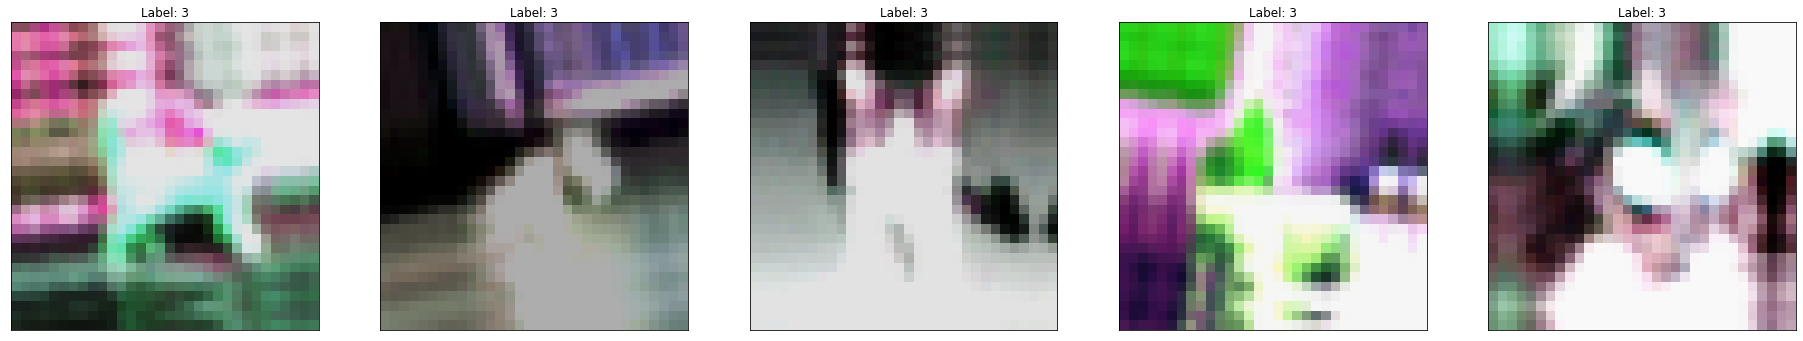

In [720]:
view_image(cats_A_alb)

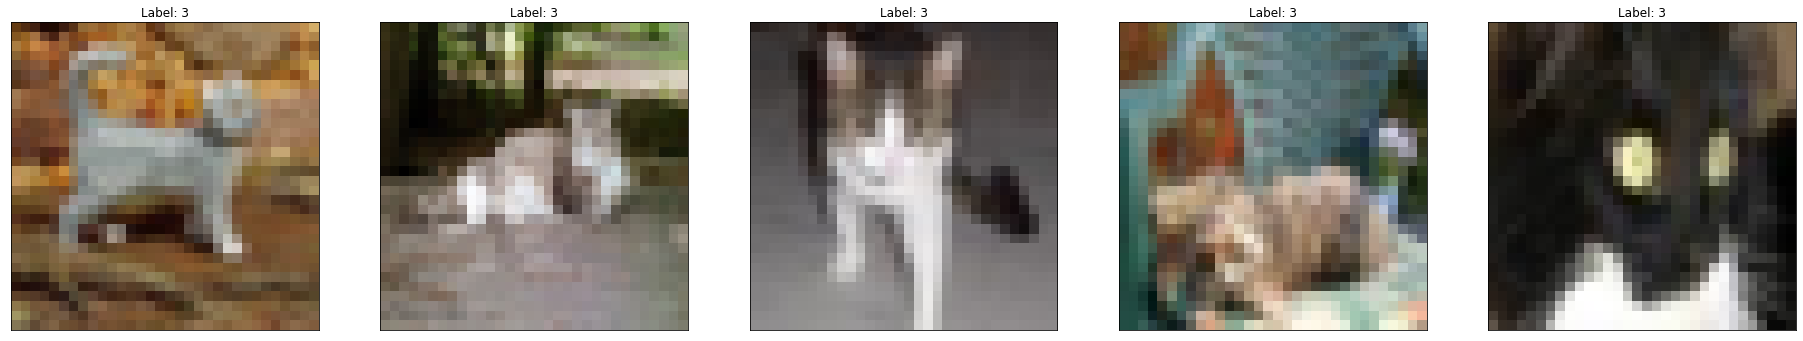

In [721]:
view_image(cats_A_noalb)

## `Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

In [722]:
stop_augmentations = time.time()
print(stop_augmentations - start_augmentations , "secs for augmenting data")

4021.3110690116882 secs for augmenting data


## Train
